In [15]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
from scipy import stats
import math

from sklearn import base, model_selection, metrics, discriminant_analysis, pipeline
from sklearn.base import BaseEstimator, TransformerMixin, clone

import seaborn as sns
import matplotlib.pyplot as plt

import constants
import dataset
import folders


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
plt.rcParams['figure.figsize']=(10,20)
sns.set(font_scale=2, palette='deep') 
sns.set_style("white")


In [3]:
ds = dataset.DatasetReader(data_path=folders.database_path, preload=True)



In [4]:
class downsampler(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.downsample_div = 10
        pass
    def fit(self, data, y=None):
        return self
    def transform(self, data):
        return data[:, :, ::self.downsample_div]

class channel_selector(BaseEstimator, TransformerMixin):
    def __init__(self, classifier_channels = [16,17,18,19,20,25,27,29,34,36,42]):
     self.classifier_channels = classifier_channels
    def fit(self, data, y=None):
        return self
    def transform(self, data):
        if self.classifier_channels:
            return data[:, self.classifier_channels, :]
        else:
            return data

class epoch_cutter(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, data, y=None):
        return self
    def transform(self, data):
        return data[:, :, int(abs(constants.epochs_tmin*constants.fs)):]

class reshaper(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, data, y=None):
        return self
    def transform(self, data):
        s = data.shape
        data= data.reshape((s[0], s[1]*s[2]))
        return data
        

class printer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, data, y=None):
        return self
    def transform(self, data):
        print (f'data shape after preproc: {data.shape}')
        return data

def score_func(y, y_pred, **kwargs):
    target_p = [a for a, b in zip(y_pred, y) if b]
    nontarget_p = [a for a, b in zip(y_pred, y) if not b]
    nontarget_p = np.array_split(nontarget_p, len(nontarget_p)/len(target_p))
    nontarget_p = np.mean(nontarget_p, axis=1)
    target_p = np.mean(target_p)
    if len(np.where(nontarget_p>target_p)[0]) == 0:
        return 1
    else:
        return 0

LDA = discriminant_analysis.LinearDiscriminantAnalysis(solver = 'lsqr', shrinkage='auto')

preproc_pipe = pipeline.make_pipeline(
        epoch_cutter(),
        channel_selector(),
        downsampler(),
        reshaper(),
        # printer()
        )

PIPE = pipeline.make_pipeline(preproc_pipe, LDA)


In [23]:
def bits_per_trial(p, n=8):
    bpm =  math.log(n, 2) 
    if p !=0:
        bpm += p*math.log(p,2) 
    if p !=1:
        bpm+=(1-p)*math.log(((1-p)/(n-1)), 2)
    return bpm

def create_dataframe(totals, rng):
    tb = pd.DataFrame({'repeats':np.ravel([[a]*len(totals[0]) for a in rng]), 'accuracy':np.ravel(totals)})
    tb['bits_per_trial']= list(map(bits_per_trial, tb['accuracy']))
    tb['itr'] = tb['bits_per_trial']*(60/(0.3*8*tb['repeats']))
    return tb

def boxplot(*args, ylabel='', xticks=['small', 'large']):
    sns.boxplot(data=args, color='white')
    sns.swarmplot(data=args)
    sns.set(context='notebook', style='whitegrid')
    sns.utils.axlabel(xlabel=None, ylabel=ylabel, fontsize=16)
    plt.xticks(plt.xticks()[0], xticks)

    st =  stats.mannwhitneyu(args[0], args[1])
    print(st)

def classifier_metrics_aggergated(ds, subset=None, n_repeats=10):
    n_stimuli = len(set(subset['event']))
    total_scores = []
    users = sorted(set(subset['user']))
    for user in users:
        user_subset = subset[subset['user'] == user]
        X = ds.create_mne_epochs_from_subset(user_subset)
        
        PIPE.fit(X._data, y=X.events[:,-1])
        skf = model_selection.StratifiedShuffleSplit(test_size=n_stimuli*n_repeats, train_size=240, n_splits=10)
        scores = model_selection.cross_val_score(PIPE,
                                X._data, 
                                X.events[:,-1],
                                cv=skf,
                                scoring=metrics.make_scorer(score_func, needs_proba=True))
        
        total_scores.append(np.mean(scores))
    return total_scores



MannwhitneyuResult(statistic=24.0, pvalue=0.024934818791194368)


Text(0.5, 0.98, 'blind')

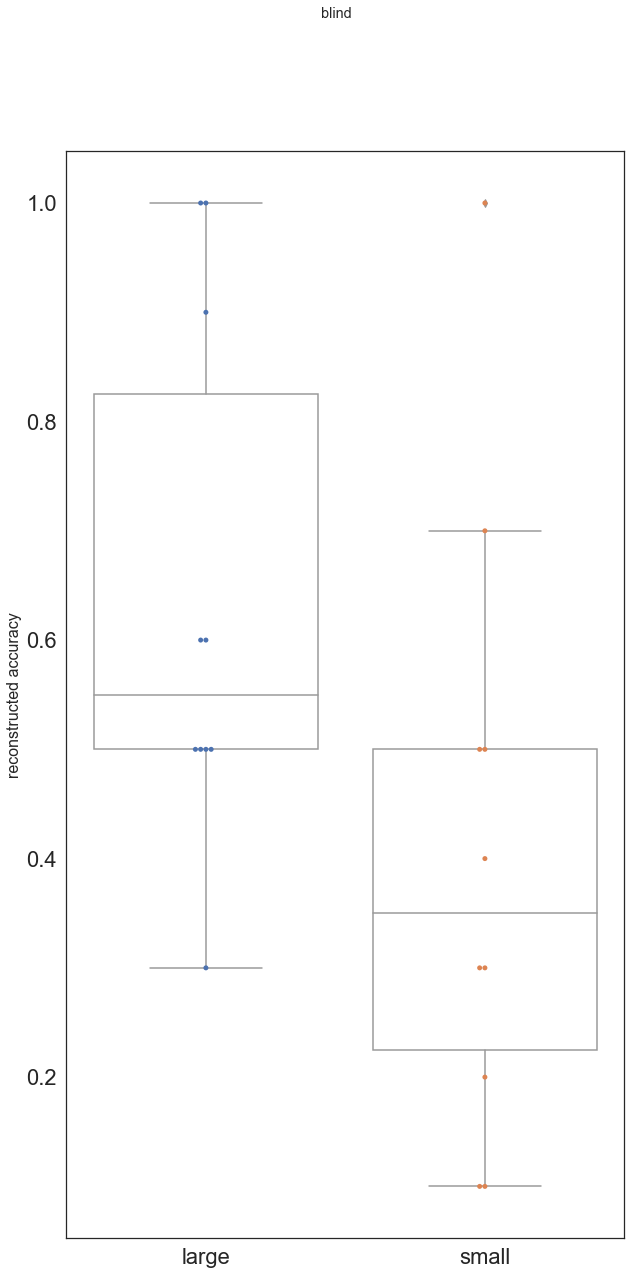

In [6]:
large_stims = classifier_metrics_aggergated(ds=ds, 
    subset= ds.markup.loc[(ds.markup['reg'] == 'brl_static6_all8') &
                          (ds.markup['blind'] == 1)]
        )

small_stims = classifier_metrics_aggergated(ds=ds, 
    subset= ds.markup.loc[(ds.markup['reg'] == 'brl_static6_all1') &
                          (ds.markup['blind'] == 1)]
        )

boxplot(large_stims, small_stims, xticks=['large', 'small'], ylabel='reconstructed accuracy')
plt.suptitle('blind')


MannwhitneyuResult(statistic=48.5, pvalue=0.46945608029241365)


Text(0.5, 0.98, 'sighted')

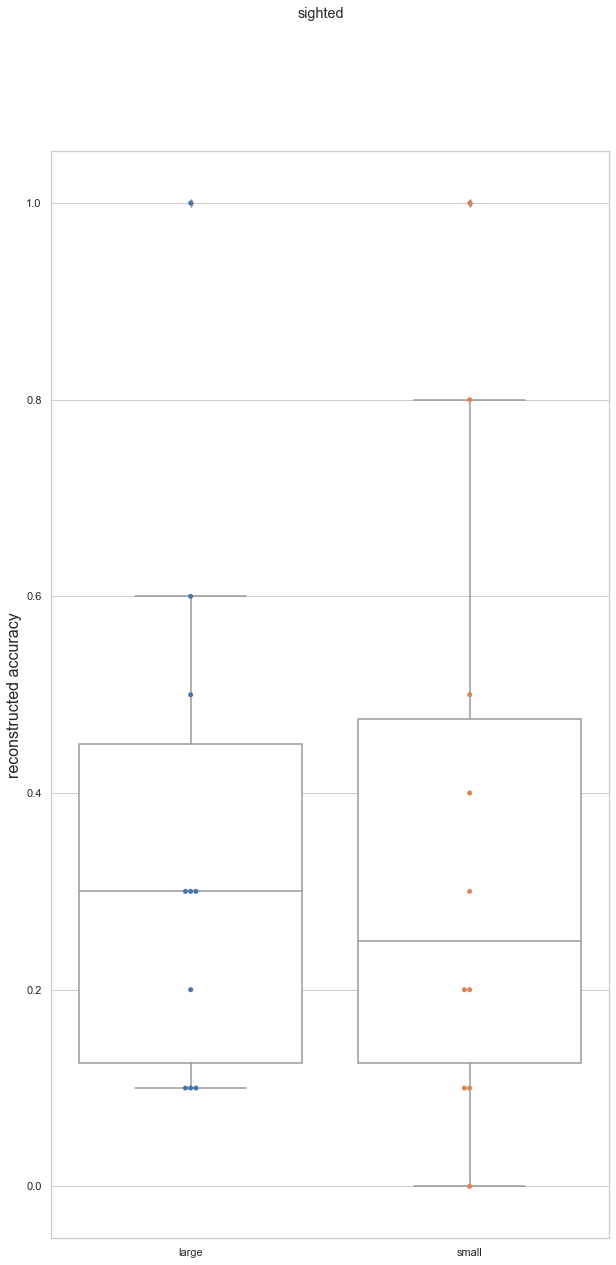

In [7]:
large_stims = classifier_metrics_aggergated(ds=ds, 
    subset= ds.markup.loc[(ds.markup['reg'] == 'brl_static6_all8') &
                          (ds.markup['blind'] == 0)]
        )

small_stims = classifier_metrics_aggergated(ds=ds, 
    subset= ds.markup.loc[(ds.markup['reg'] == 'brl_static6_all1') &
                          (ds.markup['blind'] == 0)]
        )

boxplot(large_stims, small_stims, xticks=['large', 'small'], ylabel='reconstructed accuracy')
plt.suptitle('sighted')

MannwhitneyuResult(statistic=190.5, pvalue=0.40284013967442744)


Text(0.5, 0.98, 'sighted')

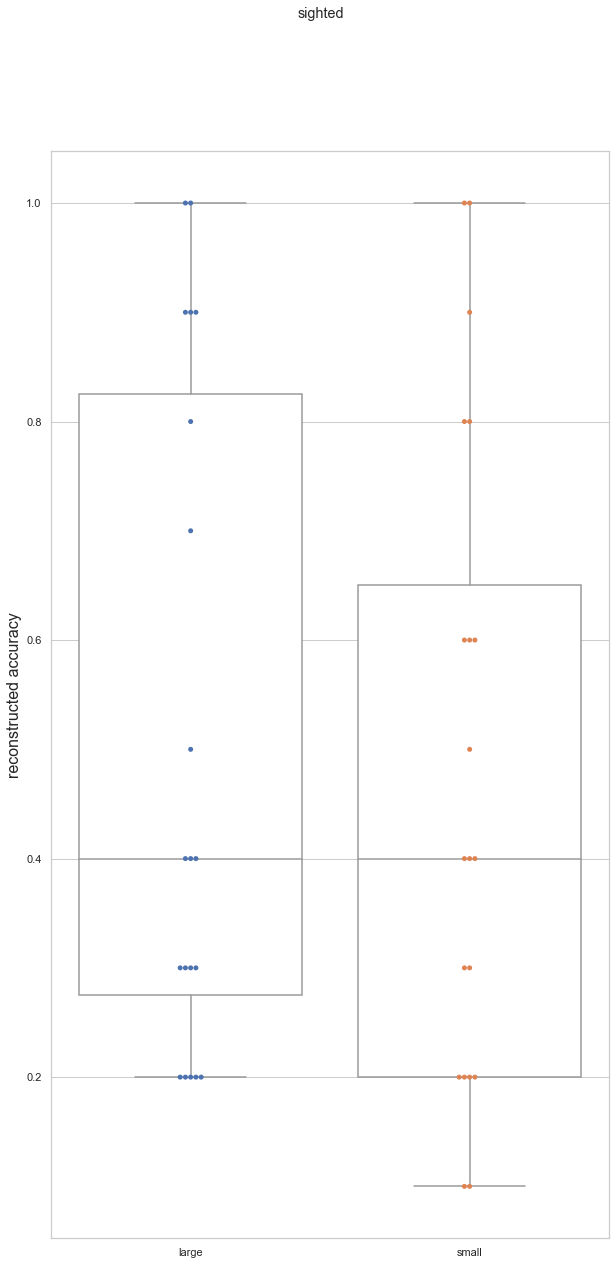

In [8]:
large_stims = classifier_metrics_aggergated(ds=ds, 
    subset= ds.markup.loc[(ds.markup['reg'] == 'brl_static6_all8')]
        )

small_stims = classifier_metrics_aggergated(ds=ds, 
    subset= ds.markup.loc[(ds.markup['reg'] == 'brl_static6_all1')]
        )

boxplot(large_stims, small_stims, xticks=['large', 'small'], ylabel='reconstructed accuracy')
plt.suptitle('sighted')

MannwhitneyuResult(statistic=9.5, pvalue=0.0011082275218956919)


Text(0.5, 0.98, 'blind vs sighted')

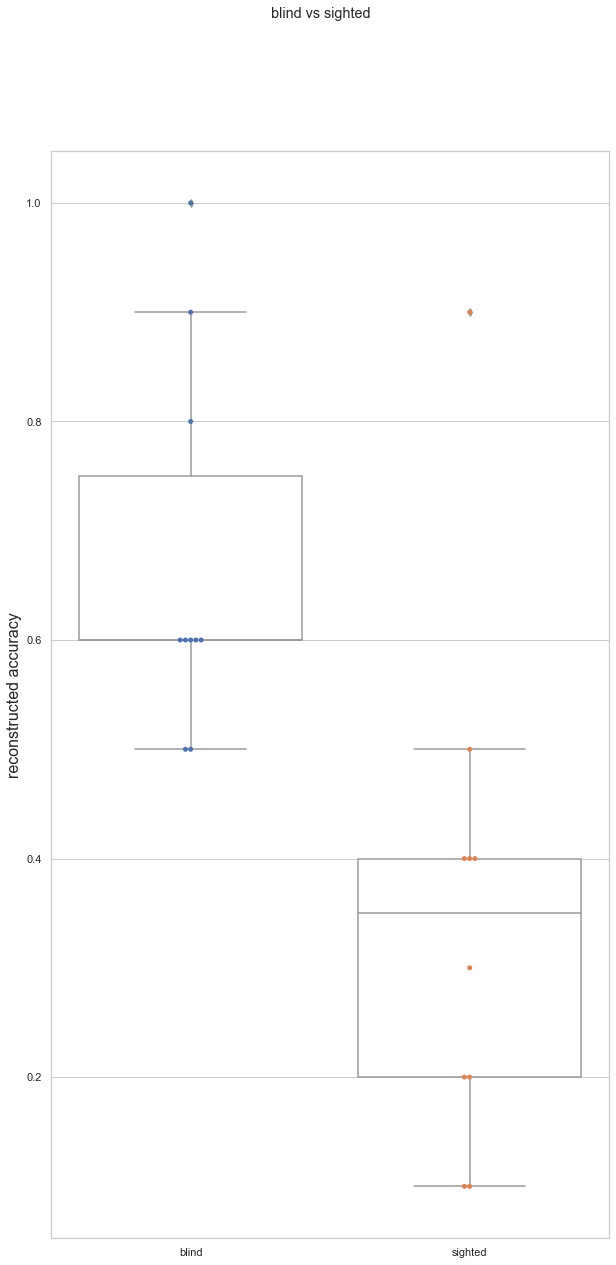

In [9]:
blind = classifier_metrics_aggergated(ds=ds, 
    subset= ds.markup.loc[(ds.markup['reg'] == 'brl_static6_all8') &
                          (ds.markup['blind'] == 1)]
        )

sighted = classifier_metrics_aggergated(ds=ds, 
    subset= ds.markup.loc[(ds.markup['reg'] == 'brl_static6_all8') &
                          (ds.markup['blind'] == 0)]
        )

boxplot(blind, sighted, xticks=['blind', 'sighted'], ylabel='reconstructed accuracy')
plt.suptitle('blind vs sighted')


MannwhitneyuResult(statistic=44.5, pvalue=0.35018347401206124)


Text(0.5, 0.98, 'blind vs sighted')

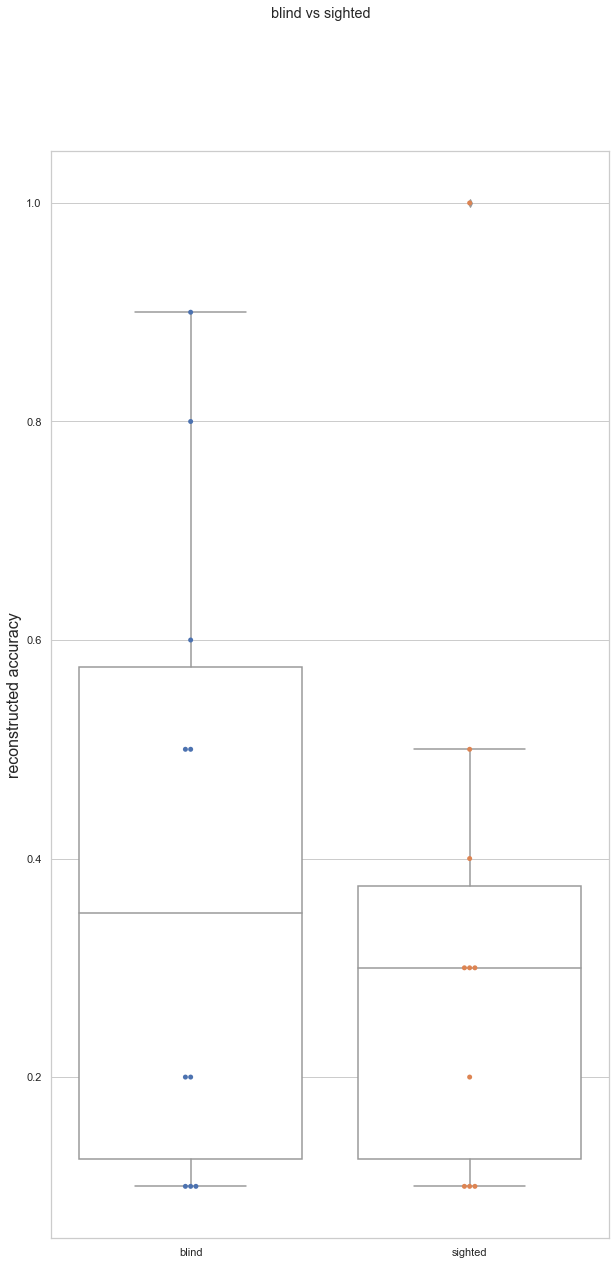

In [10]:
blind = classifier_metrics_aggergated(ds=ds, 
    subset= ds.markup.loc[(ds.markup['reg'] == 'brl_static6_all1') &
                          (ds.markup['blind'] == 1)]
        )

sighted = classifier_metrics_aggergated(ds=ds, 
    subset= ds.markup.loc[(ds.markup['reg'] == 'brl_static6_all1') &
                          (ds.markup['blind'] == 0)]
        )

boxplot(blind, sighted, xticks=['blind', 'sighted'], ylabel='reconstructed accuracy')
plt.suptitle('blind vs sighted')



In [11]:
totals_blind_large = []
totals_sighted_large = []
totals_blind_small = []
totals_sighted_small = []
rng=range(1, 12)

subset_blind = ds.markup.loc[(ds.markup['reg'] == 'brl_static6_all8') &
                             (ds.markup['blind'] == 1)
                             ]
for a in rng:
    ts = classifier_metrics_aggergated(ds, subset_blind, n_repeats=a)
    totals_blind_large.append(ts)

subset_sighted = ds.markup.loc[(ds.markup['reg'] == 'brl_static6_all8') &
                               (ds.markup['blind'] == 0)
                               ]
for a in rng:
    ts = classifier_metrics_aggergated(ds, subset_sighted, n_repeats=a)
    totals_sighted_large.append(ts)

subset_blind = ds.markup.loc[(ds.markup['reg'] == 'brl_static6_all1') &
                             (ds.markup['blind'] == 1)
                             ]
for a in rng:
    ts = classifier_metrics_aggergated(ds, subset_blind, n_repeats=a)
    totals_blind_small.append(ts)

subset_sighted = ds.markup.loc[(ds.markup['reg'] == 'brl_static6_all1') &
                               (ds.markup['blind'] == 0)
                               ]
for a in rng:
    ts = classifier_metrics_aggergated(ds, subset_sighted, n_repeats=a)
    totals_sighted_small.append(ts)

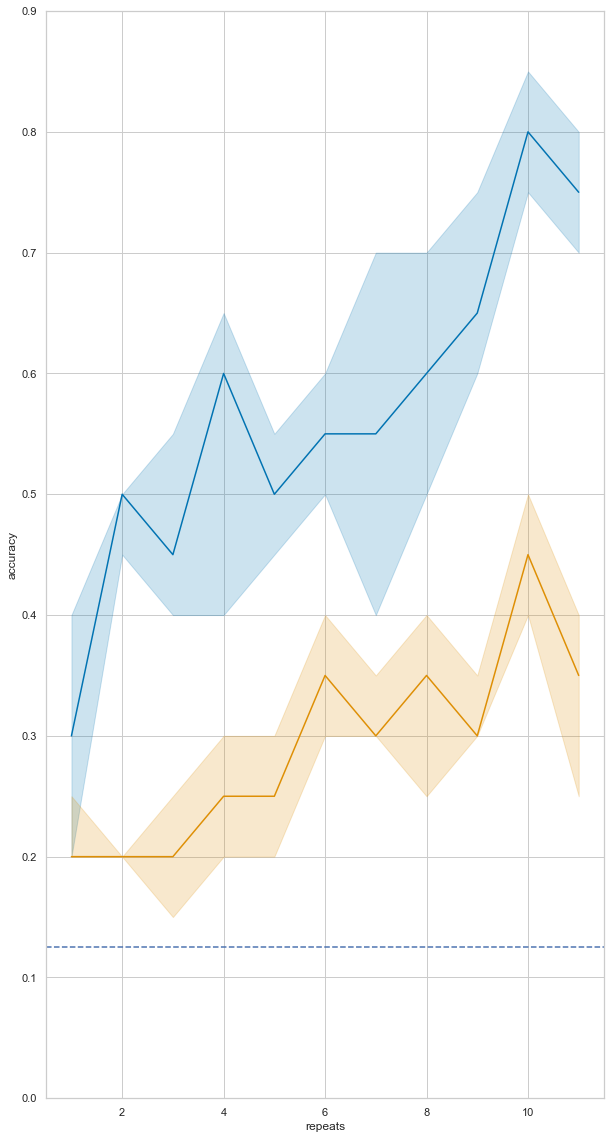

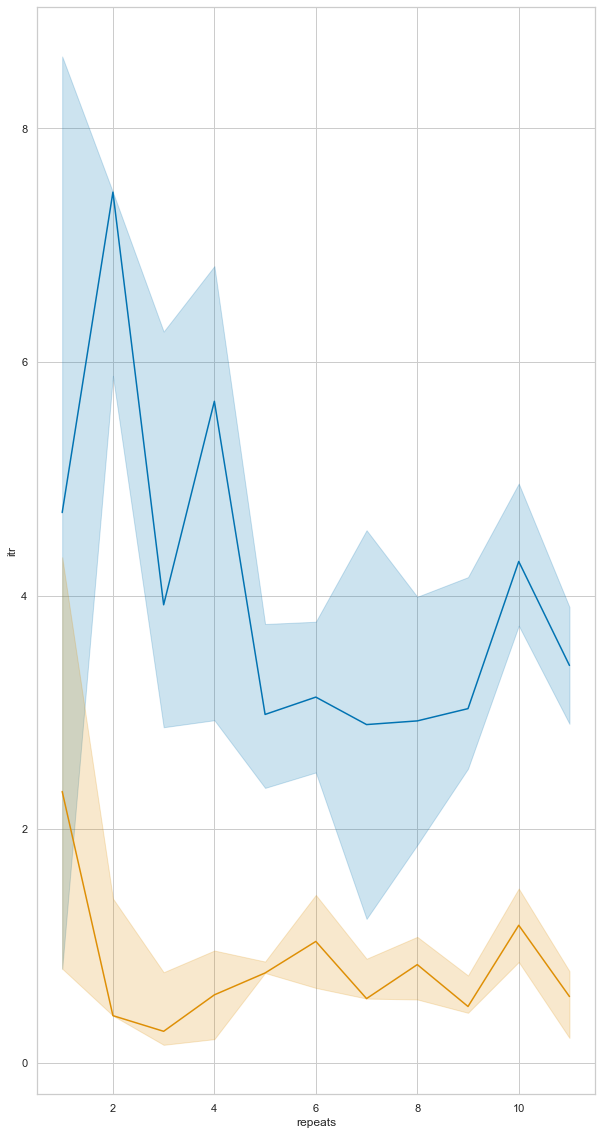

In [25]:
tb_l = create_dataframe(totals_blind_large, rng)
ts_l = create_dataframe(totals_sighted_large, rng)
tb_s = create_dataframe(totals_blind_small, rng)
ts_s = create_dataframe(totals_sighted_small, rng)

with sns.color_palette("colorblind"):
    sns.lineplot (x='repeats', y='accuracy', data=tb_l, estimator=np.median, ci=50)
    sns.lineplot (x='repeats', y='accuracy', data=ts_l, estimator=np.median, ci=50)
    plt.axhline(1/8, linestyle='--')
    plt.ylim(0,0.9)
plt.show()
with sns.color_palette("colorblind"):
    sns.lineplot (x='repeats', y='itr', data=tb_l, estimator=np.median, ci=50)
    sns.lineplot (x='repeats', y='itr', data=ts_l, estimator=np.median, ci=50)
plt.show()


In [28]:
def r2(x, y):
    return stats.kendalltau(x, y)[0] ** 2

sns.jointplot (x=tb_l['accuracy'], y=y2, kind='reg', stat_func=r2)
sns.utils.axlabel(xlabel='braille, hours/day', ylabel="braille, reading time", fontsize=16)


NameError: name 'y2' is not defined